In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import timeit
import numpy as np
from utils import tile_raster_images


In [2]:
batch_size = 20
# n_epochs = 10 
lr = 0.1
n_hid = 500
n_vis = 784
k=15
num_epoch = 15

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
class RBM(nn.Module):
    
    def __init__(self, n_vis=784, n_hid=500, kCD=1):
        super(RBM, self).__init__()
        self.vbias = nn.Parameter(torch.randn(n_vis))
        self.hbias = nn.Parameter(torch.randn(n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.kCD = kCD 
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        
    def forward(self, v, persistent=None):
        v_flat = self.flatten(v)
        v_h = v_flat
        
        if persistent is None:
            h_v, pre_h_v = self.sample_h_given_v(v_h)
            chain_start = h_v
        else:
            chain_start = persistent
            
        v_h, pre_v_h = self.sample_v_given_h(chain_start)
        
        for _ in range(self.kCD-1):
            h_v, pre_h_v = self.sample_h_given_v(v_h)
            v_h, pre_v_h = self.sample_v_given_h(h_v)
        return v_flat, v_h, pre_v_h, h_v.detach()
    
    def sample(self, v, k):
        v_flat = self.flatten(v)
        v_h = v_flat
        for _ in range(k):
            h_v, pre_h_v = self.sample_h_given_v(v_h)
            v_h, pre_v_h = self.sample_v_given_h(h_v)
        return v_flat, v_h, pre_v_h
    
    def sample_h_given_v(self, v):
        p = self.hbias  + torch.matmul(v,self.W.t())
        p = self.sigmoid(p)
        h = torch.bernoulli(p)
        return h, p
    
    def sample_v_given_h(self, h):
        p = self.vbias + h.mm(self.W)
        p = self.sigmoid(p)
        v = torch.bernoulli(p)
        return v, p
    
    def calc_free_energy(self, v):
        a = -torch.matmul(v,self.vbias)
        e = self.hbias + v.mm(self.W.t())
#         f = torch.log(1+torch.exp(e))
        f = self.softplus(e)
        g = torch.sum(f, dim=1)
        return a - g
    

def train(dataloader, model, optimizer, persistent):
    size = len(dataloader.dataset)
    
    reconstruction_cost = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        v, model_v, pre_v_h, persistent = model(X, persistent)
        model.train()
        fv = model.calc_free_energy(v)
        model_fv = model.calc_free_energy(model_v)
        loss = torch.mean(fv - model_fv)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        reconstruction_cost += get_reconstruction_cost(v, pre_v_h)
       
    return reconstruction_cost.mean(), persistent
        
def get_reconstruction_cost(target, pred):
    cross_entropy = F.binary_cross_entropy(pred, target, reduction='sum')
    return cross_entropy

# def get_pseudo_likelihood_cost(target, )

def show_and_save(img, file_name):
    r"""Show and save the image.
    Args:
        img (Tensor): The image.
        file_name (Str): The destination.
    """
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.imsave(f, npimg)   
    plt.show()

\begin{align}
                F(x) &= -\log \sum_h \exp (-E(x, h)) \\
                &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
            \end{align}

In [4]:
training_data = datasets.MNIST(
                    root="data",
                    train = True,
                    download = True, 
                    transform = transforms.ToTensor()
                    )

train_dataloader = DataLoader(training_data, batch_size=batch_size, drop_last=True)

In [5]:
start_time = timeit.default_timer()
model = RBM(n_vis=n_vis, n_hid=n_hid, kCD=k)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
persistent_chain = torch.zeros(batch_size, n_hid)
print("Starting training")
for i in range(num_epoch):
    cost, persistent_chain = train(train_dataloader, model, optimizer, persistent_chain)
    
    current_time = timeit.default_timer()
    print(f"Done {i}th epoch: Reconstruction Loss: {cost} Time: {current_time - start_time}")
    
    

Starting training
Done 0th epoch: Reconstruction Loss: 39655204.0 Time: 163.052718375
Done 1th epoch: Reconstruction Loss: 26836298.0 Time: 325.24347945799997
Done 2th epoch: Reconstruction Loss: 26723190.0 Time: 488.09497054099995
Done 3th epoch: Reconstruction Loss: 27099020.0 Time: 652.67155725
Done 4th epoch: Reconstruction Loss: 27497046.0 Time: 819.735480875
Done 5th epoch: Reconstruction Loss: 27879368.0 Time: 1000.182218875
Done 6th epoch: Reconstruction Loss: 28251784.0 Time: 1186.244583041
Done 7th epoch: Reconstruction Loss: 28581000.0 Time: 1378.436768958
Done 8th epoch: Reconstruction Loss: 28863722.0 Time: 1564.654059208
Done 9th epoch: Reconstruction Loss: 29097476.0 Time: 1748.82524175
Done 10th epoch: Reconstruction Loss: 29300984.0 Time: 1931.055687583
Done 11th epoch: Reconstruction Loss: 29395804.0 Time: 2113.728561041
Done 12th epoch: Reconstruction Loss: 29613266.0 Time: 2296.490306625
Done 13th epoch: Reconstruction Loss: 29757292.0 Time: 2476.291711291
Done 14th

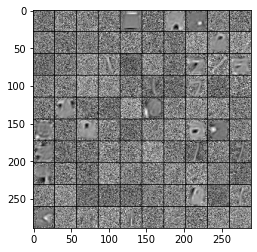

In [6]:
filter = model.W.detach().numpy()
filter_tile = tile_raster_images(filter, 
                                   img_shape=(28,28),
                                   tile_shape=(10,10),
                                   tile_spacing=(1,1))

plt.imshow(filter_tile, cmap='gray')
plt.imsave('output/filter.png', filter_tile, cmap='gray')   

In [7]:
filter.T.shape

(784, 500)

In [8]:
test_data = datasets.MNIST(
                    root="data",
                    train = True,
                    download = True, 
                    transform = transforms.ToTensor()
                    )

In [9]:
batch_size = 100
test_loader = DataLoader(test_data, batch_size=batch_size)
images = next(iter(test_loader))[0]
v, model_v, p_v_h = model.sample(images,2)

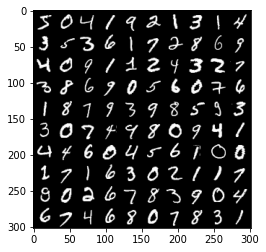

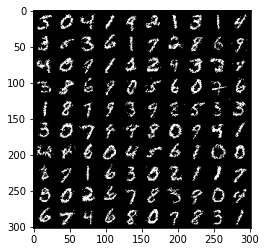

In [10]:
show_and_save(make_grid(v.view(batch_size, 1, 28,28).data, nrow=10), 'output/real')
show_and_save(make_grid(model_v.view(batch_size, 1, 28,28).data, nrow=10), 'output/sample')